<a href="https://colab.research.google.com/github/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation/blob/main/Model_Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation.git
!pip install -q -r /content/Hybrid_Transformer_for_Portfolio_Allocation/requirements.txt

Cloning into 'Hybrid_Transformer_for_Portfolio_Allocation'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 181 (delta 44), reused 14 (delta 14), pack-reused 120
Receiving objects: 100% (181/181), 20.76 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (91/91), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 3.9 MB/s eta 0:00:00


In [ ]:
from Hybrid_Transformer_for_Portfolio_Allocation.data.eq_data_loader import get_eq_data
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_hybrid import hybrid_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database

from Hybrid_Transformer_for_Portfolio_Allocation.models.hybrid_transformer_model import HybridTransformer_Portfolio
from Hybrid_Transformer_for_Portfolio_Allocation.models.benchmark_transformer_model import Transformer_Portfolio
from Hybrid_Transformer_for_Portfolio_Allocation.models.benchmark_mvp import mvp_mod

import pandas as pd
import numpy as np
import tensorflow as tf
import json

In [ ]:
data_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/data_config.json', 'r'))

In [ ]:
data = get_eq_data(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/data/nifty_50_metadata.csv',
    start = data_config['data_start_date'],
    end = data_config['data_end_date'],
    corr_thresh = data_config['correlation_thresh'],
    market_cap_filter = data_config['market_cap_filter']
)

[*********************100%%**********************]  50 of 50 completed


#### Hybrid Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
xtrain, xtest, ytrain, ytest, train_index, test_index = hybrid_transformer_database(data = data, timestep = 4, lag = 1, lagSD = 10, test_size= 0.2, purge_size = 30)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1979, 4, 34) (503, 4, 34) (1979, 17) (503, 17)


In [ ]:
Dropout = 0.1
LearningRate = 0.01
Epochs = 100
BatchSize = 128
lb = 0
ub = 0.3
num_heads = 32

xtrain = xtrain[:int(xtrain.shape[0] / BatchSize) * BatchSize, :, :]
ytrain = ytrain[:xtrain.shape[0], :]
priceData = tf.convert_to_tensor(data.loc[train_index, :].iloc[:xtrain.shape[0], :].pct_change().dropna().values, np.float32)

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

hybrid_model = HybridTransformer_Portfolio(xtrain.shape[1], xtrain.shape[2], outputShape = ytrain.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate, priceData = priceData, lb= lb, ub = ub)
hybrid_model.allocation_hybrid_train(xtrain, ytrain, Epochs = Epochs, BatchSize = BatchSize)

In [ ]:
hybrid_test_w = hybrid_model.allocation_hybrid_test(xtest)

16/16 [==============================] - 1s 5ms/step


In [ ]:
hybrid_return_mean = ((data.loc[test_index, :].pct_change().dropna() * hybrid_test_w[:-1, :]).sum(axis = 1) ).mean()
hybrid_return_std = ((data.loc[test_index, :].pct_change().dropna() * hybrid_test_w[:-1, :]).sum(axis = 1)).std()

### Transformer Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
xtrain1, xtest1, ytrain1, ytest1, train_index1, test_index1 = vanilla_transformer_database(data = data, timestep = 16, lag = 1, lagSD = 10, test_size= 0.2, purge_size = 30)

In [ ]:
Dropout = 0.05
LearningRate = 0.01
Epochs = 100
BatchSize = 8
lb = 0
ub = 0.3
num_heads = 34

xtrain1 = xtrain1[:int(xtrain1.shape[0] / BatchSize) * BatchSize, :, :]
ytrain1 = ytrain1[:xtrain1.shape[0], :]
priceData1 = tf.convert_to_tensor(data.loc[train_index, :].iloc[:xtrain1.shape[0], :].pct_change().dropna().values, np.float32)

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

vanilla_model = Transformer_Portfolio(xtrain1.shape[1], xtrain1.shape[2], outputShape = ytrain1.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate, priceData = priceData1, lb= lb, ub = ub)
vanilla_model.allocation_vanilla_train(xtrain1, ytrain1, Epochs = Epochs, BatchSize = BatchSize)

In [ ]:
vanilla_test_w = vanilla_model.allocation_vanilla_test(xtest1)

16/16 [==============================] - 0s 6ms/step


In [ ]:
vanilla_return_mean = ((data.loc[test_index1, :].pct_change().dropna() * vanilla_test_w[:-1, :]).sum(axis = 1) - 0.01 * (vanilla_test_w[1:, :] - vanilla_test_w[:-1, :]).sum(axis = 1)).mean()
vanilla_return_std = ((data.loc[test_index1, :].pct_change().dropna() * vanilla_test_w[:-1, :]).sum(axis = 1) - 0.01 * (vanilla_test_w[1:, :] - vanilla_test_w[:-1, :]).sum(axis = 1)).std()

In [ ]:
hybrid_test_w.shape, vanilla_test_w.shape

((503, 17), (500, 17))

In [ ]:
hybrid_test_w = hybrid_test_w[-vanilla_test_w.shape[0]:, :]

### MVP

In [ ]:
mvp_op_w = mvp_mod(data.iloc[-vanilla_test_w.shape[0]:, :])
mvp_w = np.array([mvp_op_w for i in range(vanilla_test_w.shape[0])])

In [ ]:
mvp_op_w

array([0.00856647, 0.06402338, 0.06398537, 0.0947953 , 0.01041231,
       0.13669369, 0.11486145, 0.00333988, 0.02750726, 0.12060538,
       0.03263281, 0.05378629, 0.09531185, 0.01018407, 0.09867394,
       0.03953562, 0.02508494])

In [ ]:
mvp_return_mean = ((data.loc[test_index1, :].pct_change().dropna() * mvp_w[:-1, :]).sum(axis = 1)).mean()
mvp_return_std = ((data.loc[test_index1, :].pct_change().dropna() * mvp_w[:-1, :]).sum(axis = 1)).std()

### Equal Weight

In [ ]:
eqw_return_mean = (data.loc[test_index1, :].pct_change().dropna() * np.ones(vanilla_test_w[:-1, :].shape) * 1 / 17).sum(axis = 1).mean()
eqw_return_std = (data.loc[test_index1, :].pct_change().dropna() * np.ones(vanilla_test_w[:-1, :].shape) * 1 / 17).sum(axis = 1).std()

### Cumulative Returns

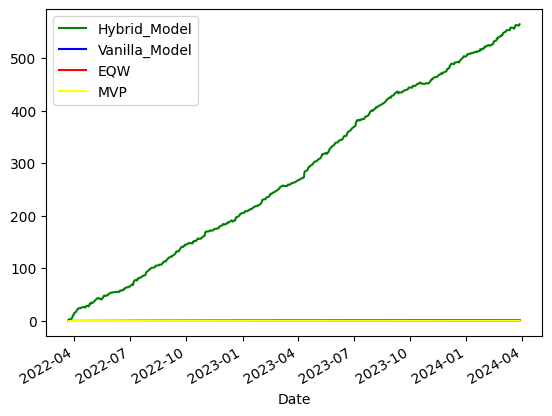

In [ ]:
import matplotlib.pyplot as plt

(((data.loc[test_index1, :].pct_change().dropna() * hybrid_test_w[1:, :]).sum(axis = 1) + 0.01 * (hybrid_test_w[1:, :] - hybrid_test_w[:-1, :]).sum(axis = 1)).cumsum() * 100).plot(color = 'green')
((data.loc[test_index1, :].pct_change().dropna() * vanilla_test_w[1:, :]).sum(axis = 1)- 0.01 * (vanilla_test_w[1:, :] - vanilla_test_w[:-1, :]).sum(axis = 1)).cumsum().plot(color = 'blue')
(data.loc[test_index1, :].pct_change().dropna() * np.ones(vanilla_test_w[1:, :].shape) * 1 / 17).sum(axis = 1).cumsum().plot(color = 'red',)
((data.loc[test_index1, :].pct_change().dropna() * mvp_w[1:, :]).sum(axis = 1)).cumsum().plot(color = 'yellow')
plt.legend(['Hybrid_Model','Vanilla_Model', 'EQW', 'MVP'])
plt.show()

In [ ]:
models = ['Hybrid', 'Vanilla', 'MVP', 'EQW']
means = [hybrid_return_mean, vanilla_return_mean, mvp_return_mean, eqw_return_mean]
stds = [hybrid_return_std, vanilla_return_std, mvp_return_std, eqw_return_std]

In [ ]:
compare_df = pd.DataFrame()
compare_df['models'] = models
compare_df['means'] = means
compare_df['stds'] = stds
compare_df['sharpe'] = compare_df.means / compare_df.stds

In [ ]:
compare_df.sort_values('means', ascending = False)

,models,means,stds,sharpe
1,Vanilla,0.001383,0.012067,0.114601
2,MVP,0.001381,0.007587,0.182050
3,EQW,0.001114,0.007385,0.150814
0,Hybrid,0.000497,0.014361,0.034638


In [ ]:
compare_df.sort_values('stds')

,models,means,stds,sharpe
3,EQW,0.001114,0.007385,0.150814
2,MVP,0.001381,0.007587,0.182050
1,Vanilla,0.001383,0.012067,0.114601
0,Hybrid,0.000497,0.014361,0.034638


In [ ]:
compare_df.sort_values('sharpe', ascending = False)

,models,means,stds,sharpe
2,MVP,0.001381,0.007587,0.182050
3,EQW,0.001114,0.007385,0.150814
1,Vanilla,0.001383,0.012067,0.114601
0,Hybrid,0.000497,0.014361,0.034638


### EDA

<Axes: xlabel='Ticker'>

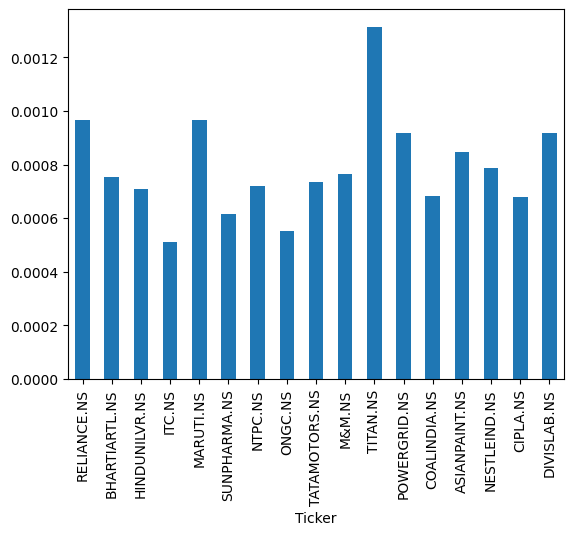

In [ ]:
data.pct_change().dropna().mean().plot(kind = 'bar')

<Axes: xlabel='Ticker'>

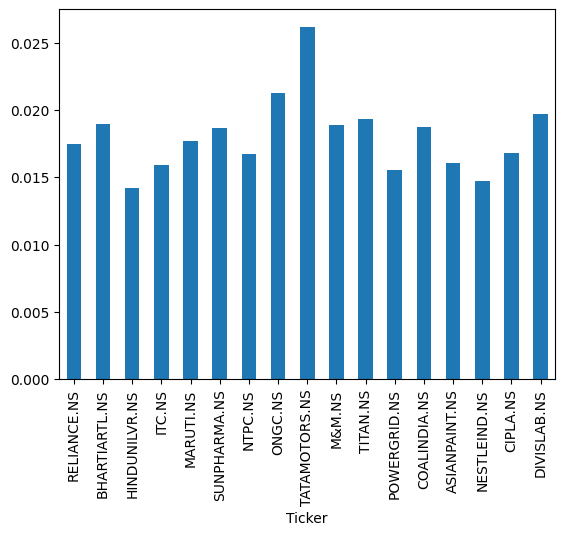

In [ ]:
data.pct_change().dropna().std().plot(kind = 'bar')